In [3]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [21]:
??verify_images

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

### The State of Deep Learning

#### Computer vision

#### Text (natural language processing)

#### Combining text and images

#### Tabular data

#### Recommendation systems

#### Other data types

### The Drivetrain Approach

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [12]:
import ddg_search

image_urls = ddg_search.search_images_ddg("dachshund")
image_urls = L(image_urls)
image_urls[0]

'https://i.pinimg.com/originals/24/72/a0/2472a0e43a5795cfa008100ccf6b24b4.jpg'

In [3]:
dest = Path("dachshund")
if not dest.exists():
    dest.mkdir()

In [13]:
download_url(image_urls[0], "dachshund/test_dachshund.jpg")

Path('dachshund/test_dachshund.jpg')

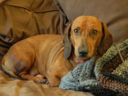

In [14]:
im = Image.open("dachshund/test_dachshund.jpg")
im.to_thumb(128,128)

In [15]:
download_images(dest, urls=image_urls)

In [20]:
fns = get_image_files(dest)
type(fns)

fastcore.foundation.L

In [28]:
fns

(#189) [Path('dachshund/00000047.jpg'),Path('dachshund/00000055.jpg'),Path('dachshund/00000154.jpg'),Path('dachshund/00000051.jpeg'),Path('dachshund/00000183.jpg'),Path('dachshund/00000063.jpeg'),Path('dachshund/00000159.jpg'),Path('dachshund/00000185.jpg'),Path('dachshund/00000057.JPG'),Path('dachshund/00000097.jpg')...]

In [109]:
bear_fns = get_image_files("../bears")
fns.extend(bear_fns)

In [25]:
failed = verify_images(fns)
failed

(#0) []

In [ ]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [41]:
doc(TensorImage)

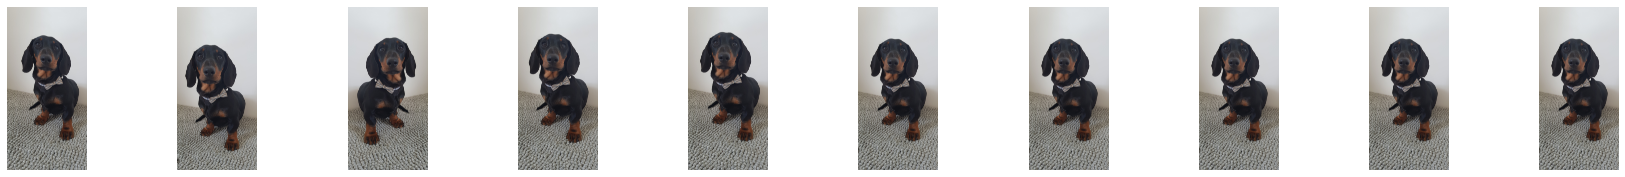

In [53]:
# Testing transformations

img = Image.open(fns[0])
# im_t = cast(array(img), TensorImage)

timg = TensorImage(array(img)).permute(2,0,1).float()/255.
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

imgs = _batch_ex(5)
# deflt = Flip()
# show_images( deflt(imgs) ,suptitle='Default Flip')

# tfm()

transformed = []

for tfm in tfms:
#     print(f'item = {item}. type = {type(item)}\n')
    transformed_images = tfm(imgs)
    for image in transformed_images:
        transformed.append(image)

show_images(transformed)

In [5]:
# The ImageDataLoaders allow one to load data and transform it.
# item_tfms : All images need to be same size. Randomly snapshot different sections of the same image instead of other
#             methods which will cause loss of information
# seed : Affects train/validation split.
# batch_tfms
block = DataBlock(blocks = (ImageBlock,CategoryBlock),
                  get_items=get_image_files,
                  splitter = RandomSplitter(seed=42),
                  get_y=parent_label,
                  item_tfms=RandomResizedCrop(224))

block = block.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms(mult=2))

In [6]:
dls = block.dataloaders("images")

Could not do one pass in your dataloader, there is something wrong in it


In [81]:
doc(DataBlock)

In [54]:
doc(ImageDataLoaders.from_folder)

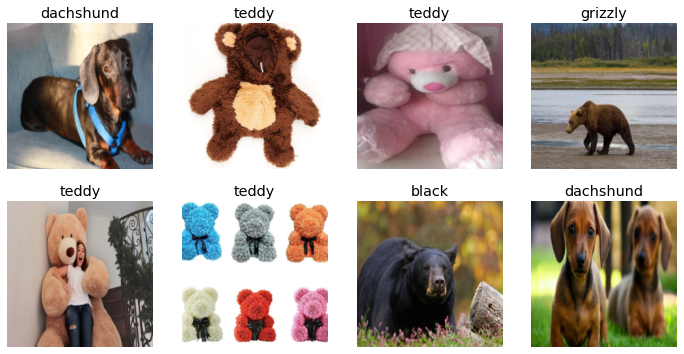

In [114]:
dls.valid.show_batch(max_n=8, nrows=2)

### Data Augmentation

## Training Your Model, and Using It to Clean Your Data

In [7]:
learner = cnn_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.304219,0.083103,0.021978,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.182078,0.105926,0.043956,00:16
1,0.154402,0.153980,0.027473,00:16
2,0.133470,0.183730,0.038462,00:17
3,0.112852,0.166271,0.032967,00:16


In [85]:
fns[0].parent.name

'dachshund'

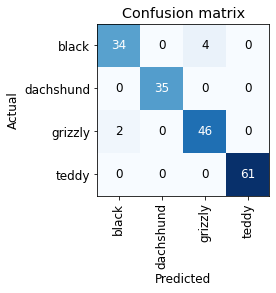

In [116]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

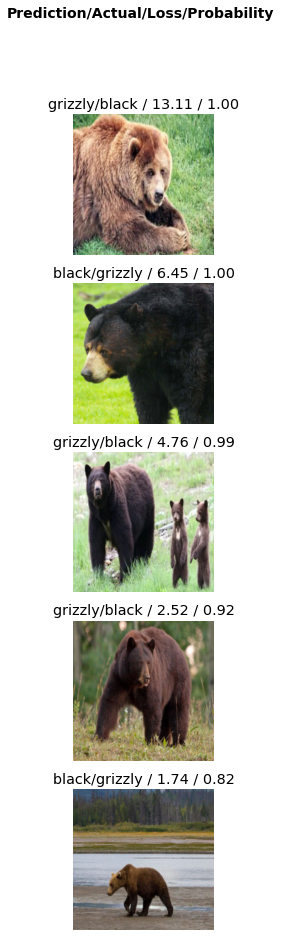

In [117]:
interp.plot_top_losses(5, nrows=5)

In [64]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [29]:
learner.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [127]:
learn_inf.predict('../images/grizzly.jpg')

('grizzly',
 TensorBase(2),
 TensorBase([6.5771e-04, 1.2525e-06, 9.9933e-01, 1.3332e-05]))

In [129]:
learn_inf.dls.vocab

['black', 'dachshund', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [9]:
btn_upload = FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [15]:
img = PILImage.create(btn_upload.data[-1])

In [27]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl:
    display(img.resize((224,224)))
out_pl

Output()

In [34]:
pred,pred_idx,probs = learn_inf.predict(img)
print(f'Prediction: {pred}; pred_idx = {pred_idx}; probs = {probs}')
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

Prediction: dachshund; pred_idx = 1; probs = TensorBase([5.6447e-06, 9.8255e-01, 6.0103e-05, 1.7389e-02])


'Prediction: dachshund; Probability: 0.9825'

In [36]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediection: {pred}; Probability: {probs[pred_idx]:0.04f}'
lbl_pred

Label(value='Prediection: dachshund; Probability: 0.9825')

In [38]:
btn_run = widgets.Button(description="Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

In [39]:
def on_click_classify():
    img = btn_upload.data[-1]
    out_pl.clear_output()
    with out_pl:
        display(img.resize(224,224))
    prediction, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'prediction = {prediction}; Probability = {pros[pred_idx]:0.04f}'
    
btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label("Select your dashchund"), btn_upload,  btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [ ]:
#hide
# !pip install voila
# !jupyter serverextension enable --sys-prefix voila 

### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
Printed image for example

1. Where do text models currently have a major deficiency?
while classification is very good with text models, summarizing, translation or generation of correct text is not very good. For example, right now there's no good way to generate accurate medical respones/information.

1. What are possible negative societal implications of text generation models?
It's very easy to generate contextually appropriate text, but hard to recognize when text has been generated by a computer or whether text is correct. Therefore it can be used to spread disinformation

1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
Pairing model with human to make human more efficient.

1. What kind of tabular data is deep learning particularly good at?
natural language in columns or high cardinality categorical variables such as zip code

1. What's a key downside of directly using a deep learning model for recommendation systems?
take longer to train

1. What are the steps of the Drivetrain Approach?
Start with _clear_ objective, then look at _levers_ you can pull to better achieve that objective, then consider the _data_ needed for achieving objective.

1. How do the steps of the Drivetrain Approach map to a recommendation system?

1. Create an image recognition model using data you curate, and deploy it on the web.

1. What is `DataLoaders`?
`DataLoaders` is a light-weight class that stores all the `DataLoader` objects making them available as `train` and `valid`

1. What four things do we need to tell fastai to create `DataLoaders`?
- Where to load data from
- how to label data
- train/validation split
- what type of data it is


1. What does the `splitter` parameter to `DataBlock` do?
split to train/validation

1. How do we ensure a random split always gives the same validation set?
`seed`

1. What letters are often used to signify the independent and dependent variables?
`y` and `x` 

1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
`crop` randomly crops a section of the image
`pad` will pad with black/white space
`squish` will squish the image to make it fit

1. What is data augmentation? Why is it needed?
Transform the data in different ways to help the model recognize different variations of the data.

1. What is the difference between `item_tfms` and `batch_tfms`?
`item_tfms` needs to do the transformation on each image individually
once all images are of same size transformations can be done using gpu using `batch_tfms`

1. What is a confusion matrix?
way to visualize output of the train/validation process

1. What does `export` save?
pickled moidel

1. What is it called when we use a model for getting predictions, instead of training?
inference

1. What are IPython widgets?
IPython widgets are used to create UI widgets in jupyter notebooks by combining javascript and python

1. When might you want to use CPU for deployment? When might GPU be better?
once model is trained, it's just a function that's being called and therefore if high parallelization isn't needed, cpu is better because it's cheaper and more widely available. gpu might be needed when high parallelization is needed.

1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
- has to always be up and running instead of just when the client needs it
- managing machines
- security considerations transferring data back and forth


1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
- not enough diversity images

1. What is "out-of-domain data"?
- data not present in the training set

1. What is "domain shift"?
- over time the domain may change

1. What are the three steps in the deployment process?


### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.